# Library import

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)

# Data Load

In [2]:
path = os.path.join(os.getcwd(), 'Data', 'DataTestComment.csv')
df_test = pd.read_csv(path)

C:\Users\nkhoa2\AppData\Local\Temp\ipykernel_13952\17680083.py:2: DtypeWarning: Columns (14,15,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(path)


In [3]:
df_test = df_test.dropna(subset=["commentBody"])                          # removes NaNs
df_test = df_test[df_test["commentBody"].str.len() > 0]                   # removes empty strings
df_sample = df_test.sample(2000, random_state=42).reset_index(drop=True)  # sample 2000 rows
df_sample.to_csv('Data/Sample.csv', index=False, mode='w+')               # save sample to CSV

quick_mode = True
if quick_mode:
    df_use = df_sample
    print("Quick mode activated. Using a smaller sample for testing.")
else:
    df_use = df_test
    print("Using the full dataset for sentiment analysis.")

comments = df_use["commentBody"].tolist()

Quick mode activated. Using a smaller sample for testing.


# Annotation

## Calling all pretrained model

In [4]:
sentiment_pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
toxicity_pipe = pipeline("text-classification", model="unitary/toxic-bert", top_k=None)

Device set to use cpu
Device set to use cpu


In [5]:
emotion_model = AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion")
emotion_tokenizer = AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion")
emotion_model.eval()  # Set the model to evaluation mode

def get_emotion(text):
    inputs = emotion_tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = emotion_model(**inputs).logits
    predicted_class = torch.argmax(logits, dim=1).item()
    label_list = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    return label_list[predicted_class]

In [6]:
hate_model = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
hate_tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
hate_model.eval()  # Set the model to evaluation mode

def get_hate_score(text):
    try:
        inputs = hate_tokenizer(text, return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = hate_model(**inputs)
            scores = torch.sigmoid(outputs.logits)
        return scores[0][0].item()
    except:
        return 0.0

In [7]:
def get_sentiment(text):
    try:
        result = sentiment_pipe(text)[0]
        label_map = {
            "LABEL_0": "negative",
            "LABEL_1": "neutral",
            "LABEL_2": "positive"
        }
        return label_map.get(result["label"], "UNKNOWN")
    except:
        return "UNKNOWN"

def get_toxicity(text):
    try:
        result = toxicity_pipe(text)[0]
        return {r['label'].lower(): r['score'] for r in result}
    except:
        return {}

In [8]:
ensemble_data = []
for comment in tqdm(comments[:2000]):  # limit to 2000 rows for now
    result = {
        "comment": comment,
        "sentiment": get_sentiment(comment),
        "hate_score": get_hate_score(comment),
        "emotion": get_emotion(comment)
    }

    toxicity_scores = get_toxicity(comment)
    for key in ['toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']:
        result[key] = toxicity_scores.get(key, 0.0)
    
    result["label"] = "unknown"  # placeholder for manual or rule-based label
    ensemble_data.append(result)

100%|██████████| 2000/2000 [14:11<00:00,  2.35it/s]


In [9]:
ensemble_data_df = pd.DataFrame(ensemble_data)
ensemble_data_df.head(10)

,comment,sentiment,hate_score,emotion,toxicity,obscene,identity_attack,insult,threat,sexual_explicit,label
0,an interesting statistic came out today in a u...,neutral,0.866758,joy,0.0,0.000181,0.0,0.000184,0.000111,0.0,unknown
1,heartily agree trump offers such a smorgasbord...,negative,0.939092,sadness,0.0,0.000290,0.0,0.000248,0.000121,0.0,unknown
2,it is ever so critical now for the average ame...,neutral,0.982114,joy,0.0,0.000183,0.0,0.000209,0.000142,0.0,unknown
3,you sold your soul no less than any of them yo...,negative,0.808653,anger,0.0,0.007351,0.0,0.068120,0.015863,0.0,unknown
4,did mr trumps people forget to tell him that h...,negative,0.870100,sadness,0.0,0.000403,0.0,0.000518,0.000147,0.0,unknown
5,there are black farmers in north carolina that...,neutral,0.938146,joy,0.0,0.000279,0.0,0.000296,0.000150,0.0,unknown
6,our manchuria candidatebut it would not have b...,negative,0.975874,joy,0.0,0.000169,0.0,0.000191,0.000121,0.0,unknown
7,obama once again demonstrates that he is capab...,neutral,0.971533,joy,0.0,0.000172,0.0,0.000178,0.000130,0.0,unknown
8,with his business first preoccupations and raw...,neutral,0.896069,joy,0.0,0.000259,0.0,0.000253,0.000116,0.0,unknown
9,trump offered the same lame excuse he always h...,negative,0.928705,sadness,0.0,0.000233,0.0,0.000241,0.000104,0.0,unknown


In [46]:
def auto_label(row):
    # Flag strong negative + hate or toxicity
    if (row['sentiment'] == 'negative' and row['emotion'] == 'anger') and (
        row['hate_score'] > 0.9 or
        row['toxicity'] > 0.8 or
        row['insult'] > 0.5 or
        row['threat'] > 0.4 or
        row['identity_attack'] > 0.5
    ):
        return "delete"

    # Even if sentiment is neutral or positive, still delete if too toxic
    
    if row['toxicity'] > 0.6 or row['insult'] > 0.6 or row['identity_attack'] > 0.6 or row['obscene'] > 0.6 or row['threat'] > 0.6 or row['sexual_explicit'] > 0.6:
        return "delete"
    

    # Emotional cue: very angry + some toxicity
    if row['emotion'] == 'anger' and row['toxicity'] > 0.4:
        return "delete"

    # Everything else is kept
    return "keep"

<Axes: xlabel='label'>

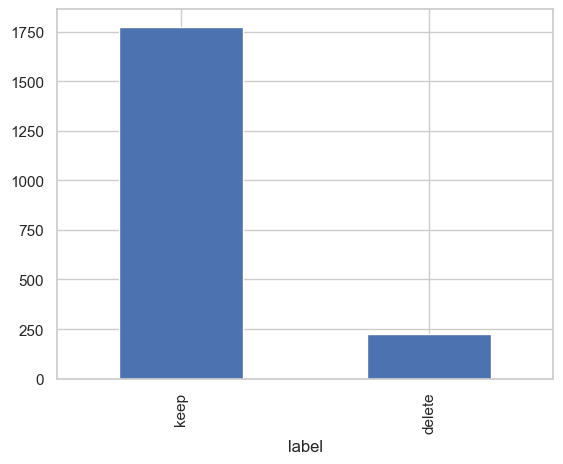

In [47]:
ensemble_data_df['label'] = ensemble_data_df.apply(auto_label, axis=1)
ensemble_data_df['label'].value_counts().plot(kind='bar')


In [48]:
ensemble_data_df[['comment', 'label']].head(10)

,comment,label
0,an interesting statistic came out today in a university of michigan study that found the michigan medicaid expansion not only insured an additional 6000 people in this state it also produced an additional 330 jobs in the michigan health care industry so much to the contrary of yet another republican argument that the act would cut jobssomething that was never born out by demographersit actually resulted in a significant uptick in hiringbut hey we now live in trumpland where everything will be judged based upon how it hits the great morass of semi to uninformed people in the gut and not based upon any significant degree of reality,keep
1,heartily agree trump offers such a smorgasbord of bombast and lies journalists can easily loose perspective and critical edge in the feeding frenzy we must remain discriminating by drilling down on what is truly consequential and walking past the cheap calories of derision and rumour trump got where he is partly because he knew how to play to the mainstream medias disastrous appetite for entertainment posing as news,keep
2,it is ever so critical now for the average american citizen to pay attention stay actively informed even on those more boring matters and actually make those calls and send those emails gone are the days of assuming elected officials will on the whole do what is right for us we are now our only hope,keep
3,you sold your soul no less than any of them you brought us trump you and the rest of the apologists,keep
4,did mr trumps people forget to tell him that hed lost the popular vote in the millionshes right about one thing of course: not enough citizens voted though its safe to say that a good many women who did arent the ones who wish they hadnt the ones who obeyed their husbands and for trump or lied to the husbands and didnt tell them wouldnt risk exposing themselves at the womens marchesthe ballot is secret so your family neighbors and friends can never guess about how humiliated one can feel after voting for the wrong candidate the voting booth is a confessional through there is nobody to absolve you,keep
5,there are black farmers in north carolina that are involved in vegetable and animal agriculture have been productive for years and would be worthy partners and vendors for this chef and her businesses i am a black yankee who did spend some time in no enough to see the differences between that part of the state and rep charlotte and experience them too as recently as this past december there was an active ask drive through in northeast north central no and there are active enclaves in eastern no unfortunately this political climate has made it much easier for these attitudes and behaviors to become apparent again including the bias that is demonstrated by your own assumptions in your comment above the michigan boy got it right this show and the business owners who appear to be benefiting the white population of this area and not the majority black residents could be more inclusive in their business practices and benefit themselves along the way also,keep
6,our manchuria candidatebut it would not have been successful if we elected candidates based on issues rather than popularity contests determined by to and now the internet in which propaganda techniques for selling soap are used to attack and establish the supposed character of the nominee,keep
7,obama once again demonstrates that he is capable of compassion which is not something for which his successortobe is exactly renowned this is the right thing to do ideally snowden would serve for the same number of years and move on as well,keep
8,with his business first preoccupations and raw understanding of the complexities of the international relations compounded further by his ready succumbing to the impulsive dictates trump would be more than willing to offer the us led world order on platter to his new found charm and alter ego putin whatever be the catastrophe,keep
9,trump offered the same lame excuse

In [49]:
def analyze_moderation_output(df, save_csv=True, csv_name="dashboard_summary.csv"):
    print("🔎 Starting moderation evaluation...")

    # 1. Label Distribution
    print("\n🔢 Label distribution (%):")
    label_dist = df["label"].value_counts(normalize=True) * 100
    print(label_dist)

    # 2. Sentiment vs Final Label
    print("\n🧠 Sentiment vs Final Label:")
    sentiment_vs_label = pd.crosstab(df['sentiment'], df['label'])
    print(sentiment_vs_label)

    # 3. Emotion vs Final Label
    print("\n❤️ Emotion vs Final Label:")
    emotion_vs_label = pd.crosstab(df['emotion'], df['label'])
    print(emotion_vs_label)

    # 4. Toxicity Stats
    print("\n📊 Toxicity Score Summary:")
    toxic_cols = ['toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
    toxic_stats = df[toxic_cols].describe()
    print(toxic_stats)

    # 5. Suspected False Positives
    print("\n🤔 Potential False Positives (NEGATIVE but non-toxic):")
    false_positives = df[
        (df['label'] == 'delete') &
        (df['toxicity'] < 0.2) &
        (df['sentiment'] == 'NEGATIVE')
    ][['comment', 'sentiment', 'toxicity', 'emotion', 'label']]
    print(false_positives.head(10))

    # 6. Visualization
    print("\n📊 Generating visualization...")
    sns.set(style="whitegrid")

    plt.figure(figsize=(7,4))
    sns.countplot(x='sentiment', hue='label', data=df)
    plt.title("Sentiment vs Moderation Label")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    sns.countplot(x='emotion', hue='label', data=df, order=df['emotion'].value_counts().index)
    plt.title("Emotion vs Moderation Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Optional: save dashboard data
    if save_csv:
        dashboard = {
            "Label Distribution (%)": label_dist,
            "Sentiment vs Label": sentiment_vs_label,
            "Emotion vs Label": emotion_vs_label,
            "Toxicity Stats": toxic_stats
        }

        # Save each to individual sheets
        with pd.ExcelWriter(csv_name.replace(".csv", ".xlsx")) as writer:
            label_dist.to_frame(name="Percentage").to_excel(writer, sheet_name="Label Dist")
            sentiment_vs_label.to_excel(writer, sheet_name="Sentiment vs Label")
            emotion_vs_label.to_excel(writer, sheet_name="Emotion vs Label")
            toxic_stats.to_excel(writer, sheet_name="Toxicity Stats")
            false_positives.to_excel(writer, sheet_name="Suspected False Positives")

        print(f"\n✅ Dashboard summary saved to: {csv_name.replace('.csv', '.xlsx')}")

    return false_positives


🔎 Starting moderation evaluation...

🔢 Label distribution (%):
label
keep      88.75
delete    11.25
Name: proportion, dtype: float64

🧠 Sentiment vs Final Label:
label      delete  keep
sentiment              
negative      225  1000
neutral         0   564
positive        0   211

❤️ Emotion vs Final Label:
label     delete  keep
emotion               
anger        222   464
fear           0    83
joy            1   893
love           0    36
sadness        2   266
surprise       0    33

📊 Toxicity Score Summary:
       toxicity      obscene  identity_attack       insult       threat  \
count    2000.0  2000.000000           2000.0  2000.000000  2000.000000   
mean        0.0     0.005082              0.0     0.009535     0.001715   
std         0.0     0.035973              0.0     0.054758     0.020150   
min         0.0     0.000144              0.0     0.000162     0.000087   
25%         0.0     0.000182              0.0     0.000189     0.000120   
50%         0.0     0.000274

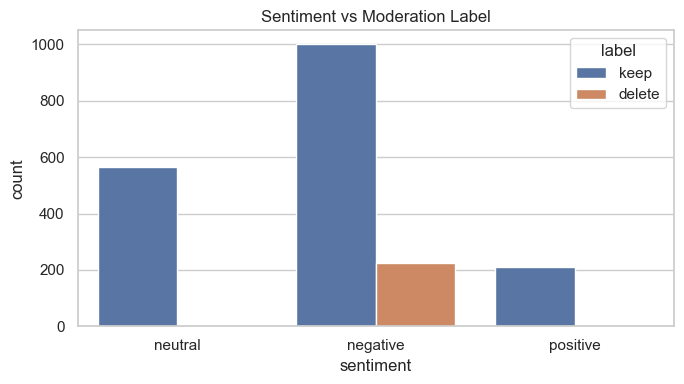

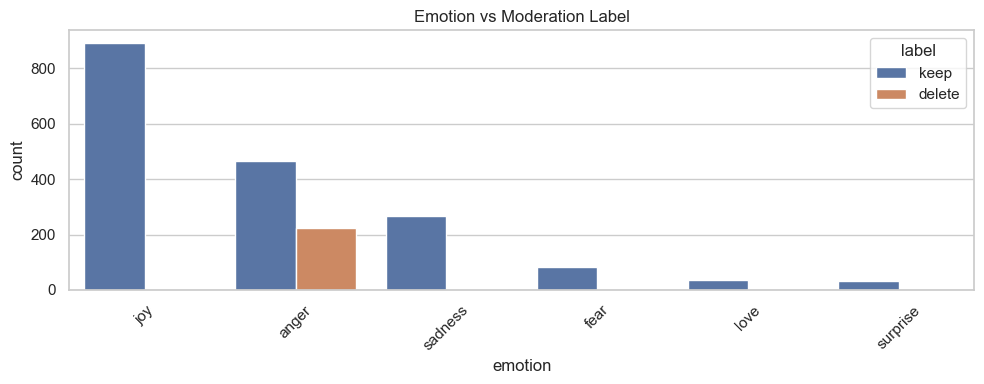


✅ Dashboard summary saved to: dashboard_summary.xlsx


In [50]:
false_positives = analyze_moderation_output(ensemble_data_df)

In [ ]:
def test_singular_comment(comment):
    result = {
        "comment": comment,
        "sentiment": get_sentiment(comment),
        "hate_score": get_hate_score(comment),
        "emotion": get_emotion(comment)
    }

    toxicity_scores = get_toxicity(comment)
    for key in ['toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']:
        result[key] = toxicity_scores.get(key, 0.0)
    
    result["label"] = auto_label(result)
    return result

test_singular_comment(r"")

{'comment': 'nice girls bad, make me get naughty. Bad yello hoe, real nice body. Down south chick, like em real thick\\"\\" http://t.co/bzRDl3kF7U\\"',
 'sentiment': 'negative',
 'hate_score': 0.14401710033416748,
 'emotion': 'love',
 'toxicity': 0.0,
 'obscene': 0.3122866451740265,
 'identity_attack': 0.0,
 'insult': 0.30979153513908386,
 'threat': 0.002638012170791626,
 'sexual_explicit': 0.0,
 'label': 'keep'}